- Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
-  Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
-  Использовать CrossEntropyLoss и L2-регуляризацию.
-  Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
-  * (**+2 балла**) Добавить Batch normalization.
-  * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
-  * (**+1 балл**) Также реализовать оптимизатор Adam.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
from urllib.request import urlretrieve
import os
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pickle

## 1. Предобработка

In [8]:
def download_svhn():
    if not os.path.exists('train_32x32.mat'):
        print("Downloading training data...")
        urlretrieve('http://ufldl.stanford.edu/housenumbers/train_32x32.mat', 'train_32x32.mat')

    if not os.path.exists('test_32x32.mat'):
        print("Downloading test data...")
        urlretrieve('http://ufldl.stanford.edu/housenumbers/test_32x32.mat', 'test_32x32.mat')

    print("Download complete!")

download_svhn()

Download complete!


In [9]:
def load_svhn():
    train_data = sio.loadmat('train_32x32.mat')
    X_train = train_data['X'].transpose((3, 0, 1, 2))
    y_train = train_data['y'].flatten()
    y_train[y_train == 10] = 0

    test_data = sio.loadmat('test_32x32.mat')
    X_test = test_data['X'].transpose((3, 0, 1, 2))
    y_test = test_data['y'].flatten()
    y_test[y_test == 10] = 0

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_svhn()

In [10]:
def preprocess_data(X_train, X_val, X_test):
    X_train_flat = X_train.reshape(X_train.shape[0], -1).astype(np.float32)
    X_val_flat = X_val.reshape(X_val.shape[0], -1).astype(np.float32)
    X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(np.float32)

    # normalize
    X_train_flat = X_train_flat / 255.0
    X_val_flat = X_val_flat / 255.0
    X_test_flat = X_test_flat / 255.0

    mean = np.mean(X_train_flat, axis=0)
    std = np.std(X_train_flat, axis=0) + 1e-8

    X_train_flat = (X_train_flat - mean) / std
    X_val_flat = (X_val_flat - mean) / std
    X_test_flat = (X_test_flat - mean) / std

    return X_train_flat, X_val_flat, X_test_flat, mean, std

X_train_flat, X_val_flat, X_test_flat, mean, std = preprocess_data(X_train, X_val, X_test)

Training data shape: (58605, 3072)
Validation data shape: (14652, 3072)
Test data shape: (26032, 3072)
Number of classes: 10


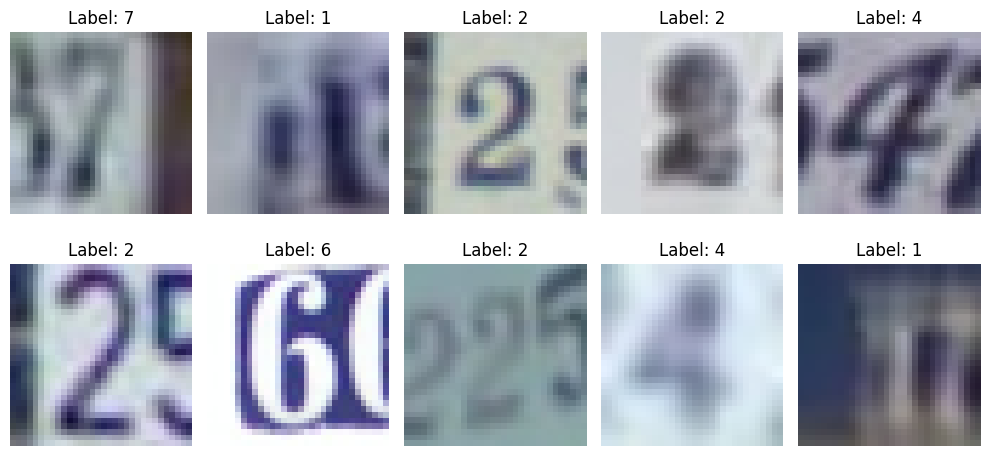

In [11]:
print(f"Training data shape: {X_train_flat.shape}")
print(f"Validation data shape: {X_val_flat.shape}")
print(f"Test data shape: {X_test_flat.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Классы сети

In [12]:
class FullyConnectedLayer:
    def __init__(self, input_size, output_size):
        # xavier initialization
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / (input_size + output_size))
        self.biases = np.zeros(output_size)

        self.dweights = np.zeros_like(self.weights)

        self.dbiases = np.zeros_like(self.biases)

        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        self.output = np.dot(x, self.weights) + self.biases
        return self.output

    def backward(self, grad_output):
        self.dweights = np.dot(self.input.T, grad_output)
        self.dbiases = np.sum(grad_output, axis=0)

        grad_input = np.dot(grad_output, self.weights.T)
        return grad_input

    def get_parameters(self):
        return [(self.weights, self.dweights), (self.biases, self.dbiases)]

    def get_l2_reg(self, reg_strength):
        reg_loss = 0.5 * reg_strength * np.sum(self.weights ** 2)
        self.dweights += reg_strength * self.weights
        return reg_loss

In [13]:
class ReluLayer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        self.output = np.maximum(0, x)
        return self.output

    def backward(self, grad_output):
        grad_input = grad_output * (self.input > 0)
        return grad_input

    def get_parameters(self):
        return []

    def get_l2_reg(self, reg_strength):
        return 0

In [14]:
class BatchNormLayer:
    def __init__(self, input_size, momentum=0.9, epsilon=1e-5):
        self.gamma = np.ones(input_size)
        self.beta = np.zeros(input_size)
        self.momentum = momentum
        self.epsilon = epsilon

        self.running_mean = np.zeros(input_size)
        self.running_var = np.ones(input_size)

        self.dgamma = None
        self.dbeta = None

        self.input = None
        self.normalized = None
        self.batch_mean = None
        self.batch_var = None
        self.std = None
        self.is_training = True

    def forward(self, x, training=True):
        self.is_training = training
        self.input = x

        if training:
            self.batch_mean = np.mean(x, axis=0)
            self.batch_var = np.var(x, axis=0) + self.epsilon
            self.std = np.sqrt(self.batch_var)

            self.normalized = (x - self.batch_mean) / self.std

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
        else:
            self.normalized = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon)

        return self.gamma * self.normalized + self.beta

    def backward(self, grad_output):
        batch_size = self.input.shape[0]

        self.dgamma = np.sum(grad_output * self.normalized, axis=0)
        self.dbeta = np.sum(grad_output, axis=0)

        dxhat = grad_output * self.gamma

        dvar = np.sum(dxhat * (self.input - self.batch_mean) * -0.5 * (self.batch_var ** -1.5), axis=0)

        dmean = np.sum(dxhat * -1.0 / self.std, axis=0) + dvar * np.mean(-2.0 * (self.input - self.batch_mean), axis=0)

        dx = dxhat / self.std + dvar * 2.0 * (self.input - self.batch_mean) / batch_size + dmean / batch_size

        return dx

    def get_parameters(self):
        return [(self.gamma, self.dgamma), (self.beta, self.dbeta)]

    def get_l2_reg(self, reg_strength):
        return 0

## 3.Реализация функции loss

In [15]:
def softmax(x):
    shifted = x - np.max(x, axis=1, keepdims=True)
    exp_scores = np.exp(shifted)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

class CrossEntropyLoss:
    def __init__(self):
        self.probs = None
        self.labels = None
        self.batch_size = None

    def forward(self, scores, labels):
        self.batch_size = scores.shape[0]
        self.labels = labels

        self.probs = softmax(scores)

        correct_logprobs = -np.log(self.probs[range(self.batch_size), labels])
        loss = np.sum(correct_logprobs) / self.batch_size

        return loss

    def backward(self):
        dx = self.probs.copy()

        dx[range(self.batch_size), self.labels] -= 1

        dx /= self.batch_size

        return dx

## 4. Реализации оптимизаторов

In [16]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, params):
        for param, grad in params:
            param -= self.learning_rate * grad

In [17]:
class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = {}

    def update(self, params):
        for i, (param, grad) in enumerate(params):
            if i not in self.velocity:
                self.velocity[i] = np.zeros_like(param)

            self.velocity[i] = self.momentum * self.velocity[i] - self.learning_rate * grad

            param += self.velocity[i]

In [18]:
class RMSprop:
    def __init__(self, learning_rate=0.01, decay_rate=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.cache = {}

    def update(self, params):
        for i, (param, grad) in enumerate(params):
            if i not in self.cache:
                self.cache[i] = np.zeros_like(param)

            self.cache[i] = self.decay_rate * self.cache[i] + (1 - self.decay_rate) * (grad ** 2)

            param -= self.learning_rate * grad / (np.sqrt(self.cache[i]) + self.epsilon)

In [19]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, params):
        self.t += 1

        for i, (param, grad) in enumerate(params):
            if i not in self.m:
                self.m[i] = np.zeros_like(param)
                self.v[i] = np.zeros_like(param)

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad

            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

            m_corrected = self.m[i] / (1 - self.beta1 ** self.t)
            v_corrected = self.v[i] / (1 - self.beta2 ** self.t)

            param -= self.learning_rate * m_corrected / (np.sqrt(v_corrected) + self.epsilon)

## 5. Neural Network Model

In [20]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, use_batchnorm=False):
        self.layers = []

        self.layers.append(FullyConnectedLayer(input_size, hidden_size))

        if use_batchnorm:
            self.layers.append(BatchNormLayer(hidden_size))

        self.layers.append(ReluLayer())

        self.layers.append(FullyConnectedLayer(hidden_size, output_size))

        self.loss_function = CrossEntropyLoss()

        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

    def forward(self, X, training=True):
        output = X
        for layer in self.layers:
            if isinstance(layer, BatchNormLayer):
                output = layer.forward(output, training)
            else:
                output = layer.forward(output)
        return output

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)

    def get_parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.get_parameters())
        return params

    def compute_l2_reg_loss(self, reg_strength):
        reg_loss = 0
        for layer in self.layers:
            reg_loss += layer.get_l2_reg(reg_strength)
        return reg_loss

    def train_step(self, X_batch, y_batch, optimizer, reg_strength):
        scores = self.forward(X_batch, training=True)

        loss = self.loss_function.forward(scores, y_batch)

        reg_loss = self.compute_l2_reg_loss(reg_strength)
        total_loss = loss + reg_loss

        grad_scores = self.loss_function.backward()
        self.backward(grad_scores)

        optimizer.update(self.get_parameters())

        return total_loss

    def predict(self, X):
        scores = self.forward(X, training=False)
        return np.argmax(scores, axis=1)

    def compute_accuracy(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

    def compute_loss(self, X, y, reg_strength):
        scores = self.forward(X, training=False)

        loss = self.loss_function.forward(scores, y)

        reg_loss = 0
        for layer in self.layers:
            if isinstance(layer, FullyConnectedLayer):
                reg_loss += 0.5 * reg_strength * np.sum(layer.weights ** 2)

        return loss + reg_loss

    def train(self, X_train, y_train, X_val, y_val,
              batch_size=64, epochs=10,
              optimizer=None, reg_strength=1e-3,
              verbose=True):

        if optimizer is None:
            optimizer = SGD(learning_rate=0.01)

        num_train = X_train.shape[0]
        iterations_per_epoch = max(num_train // batch_size, 1)

        for epoch in range(epochs):
            indices = np.random.permutation(num_train)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]

            epoch_loss = 0
            for i in range(0, num_train, batch_size):
                X_batch = X_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]

                loss = self.train_step(X_batch, y_batch, optimizer, reg_strength)
                epoch_loss += loss

                epoch_loss /= iterations_per_epoch

                train_accuracy = self.compute_accuracy(X_train, y_train)
                val_accuracy = self.compute_accuracy(X_val, y_val)
                val_loss = self.compute_loss(X_val, y_val, reg_strength)

                self.train_loss_history.append(epoch_loss)
                self.val_loss_history.append(val_loss)
                self.train_acc_history.append(train_accuracy)
                self.val_acc_history.append(val_accuracy)

                if verbose:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        return self.train_loss_history, self.val_loss_history, self.train_acc_history, self.val_acc_history

    def check_gradients(self, X, y, reg_strength=1e-3, epsilon=1e-7):
        scores = self.forward(X)
        loss = self.loss_function.forward(scores, y)
        reg_loss = self.compute_l2_reg_loss(reg_strength)
        total_loss = loss + reg_loss

        grad_scores = self.loss_function.backward()
        self.backward(grad_scores)

        params = self.get_parameters()

        for i, (param, grad) in enumerate(params):
            param_flat = param.flatten()
            grad_flat = grad.flatten()

            num_checks = min(10, len(param_flat))
            indices = np.random.choice(len(param_flat), num_checks, replace=False)

            for idx in indices:
                old_val = param_flat[idx]

                param_flat[idx] = old_val + epsilon
                param.flat[idx] = param_flat[idx]
                scores_plus = self.forward(X)
                loss_plus = self.loss_function.forward(scores_plus, y)
                reg_loss_plus = self.compute_l2_reg_loss(reg_strength)
                loss_plus_total = loss_plus + reg_loss_plus

                param_flat[idx] = old_val - epsilon
                param.flat[idx] = param_flat[idx]
                scores_minus = self.forward(X)
                loss_minus = self.loss_function.forward(scores_minus, y)
                reg_loss_minus = self.compute_l2_reg_loss(reg_strength)
                loss_minus_total = loss_minus + reg_loss_minus

                param_flat[idx] = old_val
                param.flat[idx] = old_val

                grad_num = (loss_plus_total - loss_minus_total) / (2 * epsilon)

                rel_error = abs(grad_num - grad_flat[idx]) / (abs(grad_num) + abs(grad_flat[idx]) + 1e-12)

                if rel_error > 1e-2:
                    print(f"Parameter {i}, index {idx}: Numerical: {grad_num:.8f}, Analytical: {grad_flat[idx]:.8f}, Relative Error: {rel_error:.8f}")
                else:
                    print(f"Parameter {i}, index {idx}: Numerical: {grad_num:.8f}, Analytical: {grad_flat[idx]:.8f}, Relative Error: {rel_error:.8f} - OK")

# 6. Обучение и оценка

In [21]:
input_size = X_train_flat.shape[1]
hidden_size = 512
output_size = 10
batch_size = 512
epochs = 2
reg_strength = 1e-4

Checking gradients...
Parameter 0, index 376106: Numerical: 0.00143770, Analytical: 0.00144011, Relative Error: 0.00083960 - OK
Parameter 0, index 882615: Numerical: 0.00375429, Analytical: 0.00375345, Relative Error: 0.00011145 - OK
Parameter 0, index 1409490: Numerical: -0.00200577, Analytical: -0.00200645, Relative Error: 0.00017008 - OK
Parameter 0, index 659831: Numerical: 0.00128313, Analytical: 0.00128582, Relative Error: 0.00104583 - OK
Parameter 0, index 95740: Numerical: 0.00305520, Analytical: 0.00305819, Relative Error: 0.00048758 - OK
Parameter 0, index 367560: Numerical: 0.00440307, Analytical: 0.00440048, Relative Error: 0.00029365 - OK
Parameter 0, index 1106728: Numerical: -0.00275185, Analytical: -0.00274846, Relative Error: 0.00061653 - OK
Parameter 0, index 585100: Numerical: 0.00084249, Analytical: 0.00084262, Relative Error: 0.00007399 - OK
Parameter 0, index 117295: Numerical: -0.00266443, Analytical: -0.00265930, Relative Error: 0.00096418 - OK
Parameter 0, inde

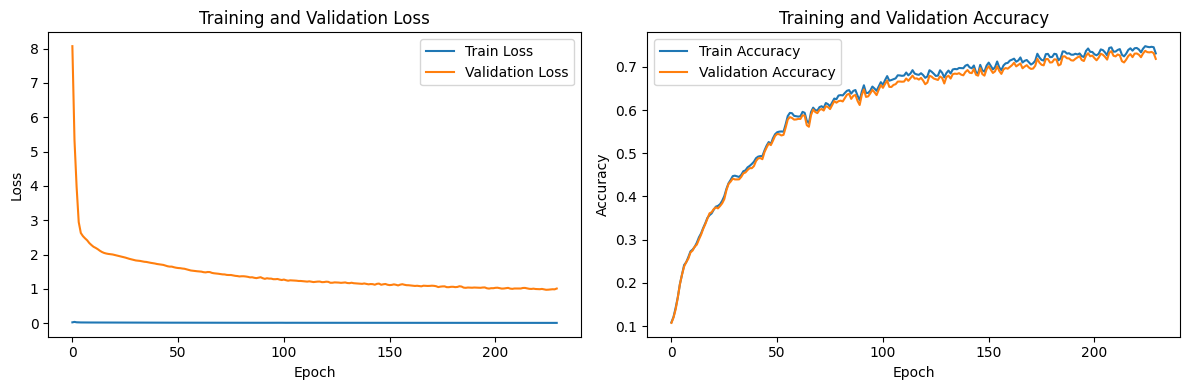

Model saved to 'svhn_model.pkl'


In [30]:
def create_batch_indices(dataset_size, batch_size):
    """Create batch indices for mini-batch training."""
    indices = np.random.permutation(dataset_size)
    batch_indices = [indices[i:i+batch_size] for i in range(0, dataset_size, batch_size)]
    return batch_indices


model = NeuralNetwork(input_size, hidden_size, output_size, use_batchnorm=True)

print("Checking gradients...")
X_check = X_train_flat[:100]
y_check = y_train[:100]
model.check_gradients(X_check, y_check, reg_strength=reg_strength)

optimizer = Adam(learning_rate=0.001, beta1=0.9, beta2=0.999)

print("\nTraining model...")
train_loss, val_loss, train_acc, val_acc = model.train(
    X_train_flat, y_train, X_val_flat, y_val,
    batch_size=batch_size, epochs=epochs,
    optimizer=optimizer, reg_strength=reg_strength,
    verbose=True
)

test_accuracy = model.compute_accuracy(X_test_flat, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

with open('svhn_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved to 'svhn_model.pkl'")

# 7. Анализ моделей и сравнительная оптимизация


Training with SGD, learning_rate=0.01...
SGD test accuracy: 0.5308

Training with Momentum, learning_rate=0.01...
Momentum test accuracy: 0.7052

Training with RMSprop, learning_rate=0.001...
RMSprop test accuracy: 0.5277

Training with Adam, learning_rate=0.001...
Adam test accuracy: 0.6984


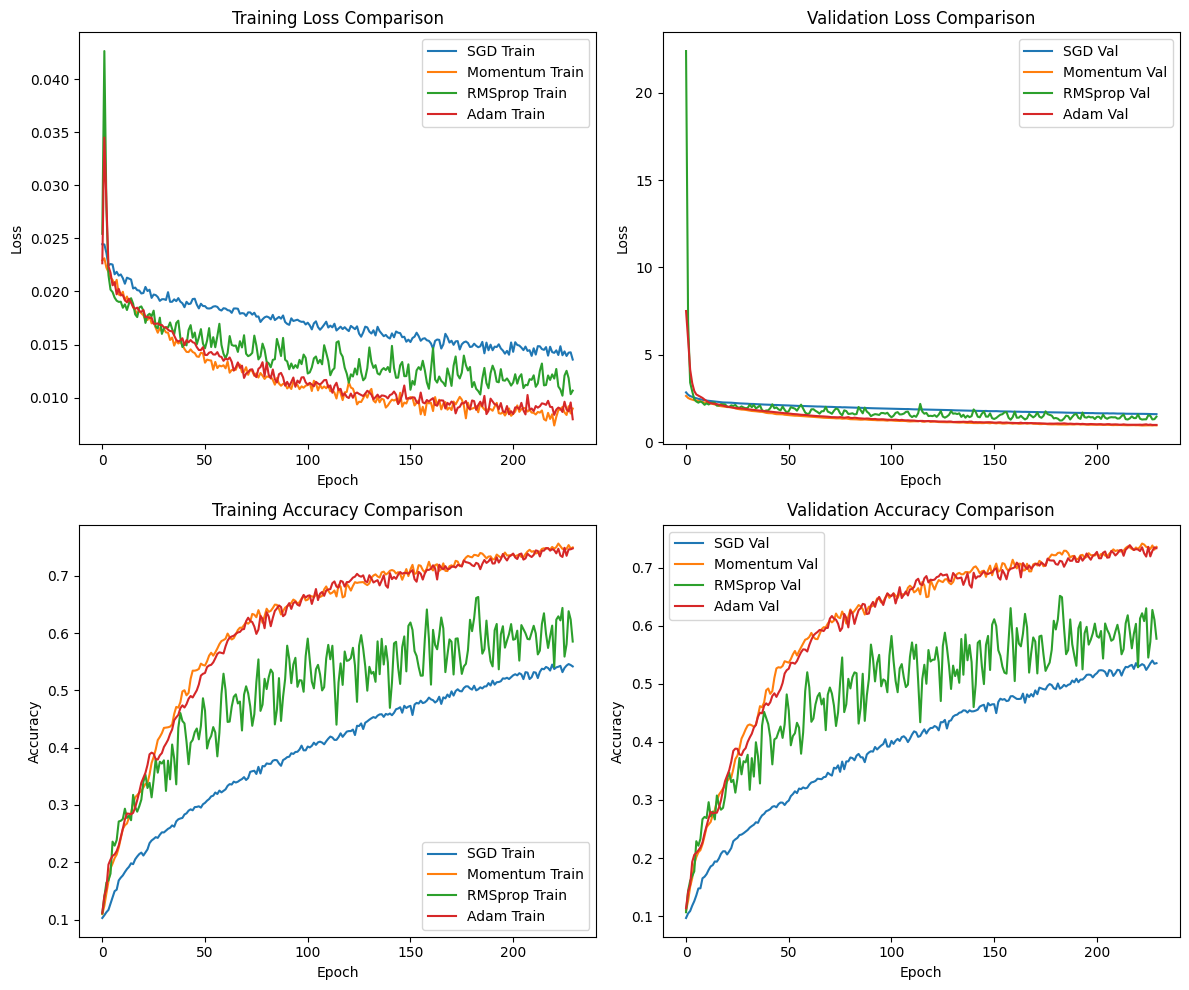

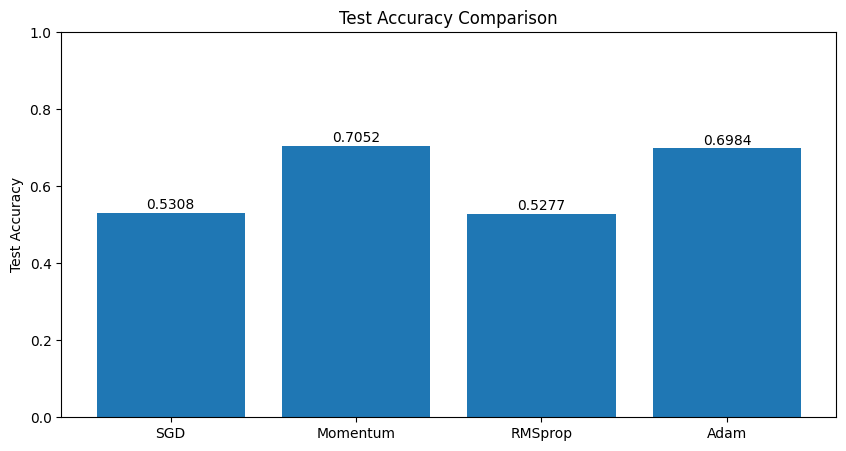

In [16]:
def train_and_evaluate(model, optimizer_name, learning_rate):
    if optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'Momentum':
        optimizer = Momentum(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate, decay_rate=0.9)
    elif optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate, beta1=0.9, beta2=0.999)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    print(f"\nTraining with {optimizer_name}, learning_rate={learning_rate}...")

    train_loss, val_loss, train_acc, val_acc = model.train(
        X_train_flat, y_train, X_val_flat, y_val,
        batch_size=batch_size, epochs=epochs,
        optimizer=optimizer, reg_strength=reg_strength,
        verbose=False
    )

    test_accuracy = model.compute_accuracy(X_test_flat, y_test)
    print(f"{optimizer_name} test accuracy: {test_accuracy:.4f}")

    return train_loss, val_loss, train_acc, val_acc, test_accuracy

optimizers = [
    ('SGD', 0.01),
    ('Momentum', 0.01),
    ('RMSprop', 0.001),
    ('Adam', 0.001)
]

results = {}

for optimizer_name, lr in optimizers:
    model = NeuralNetwork(input_size, hidden_size, output_size, use_batchnorm=True)

    train_loss, val_loss, train_acc, val_acc, test_acc = train_and_evaluate(model, optimizer_name, lr)

    results[optimizer_name] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc
    }

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
for name in results:
    plt.plot(results[name]['train_loss'], label=f'{name} Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

plt.subplot(2, 2, 2)
for name in results:
    plt.plot(results[name]['val_loss'], label=f'{name} Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()

plt.subplot(2, 2, 3)
for name in results:
    plt.plot(results[name]['train_acc'], label=f'{name} Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()

plt.subplot(2, 2, 4)
for name in results:
    plt.plot(results[name]['val_acc'], label=f'{name} Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()

test_accuracies = {name: results[name]['test_acc'] for name in results}
plt.figure(figsize=(10, 5))
plt.bar(test_accuracies.keys(), test_accuracies.values())
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
for i, (name, acc) in enumerate(test_accuracies.items()):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.ylim(0, 1.0)
plt.show()



Momentum и Adam заметно превосходят SGD и RMSprop для данной задачи.

# 8. Влияние batch нормализации


Comparing models with and without batch normalization...
Test accuracy without batch normalization: 0.6414
Test accuracy with batch normalization: 0.6776


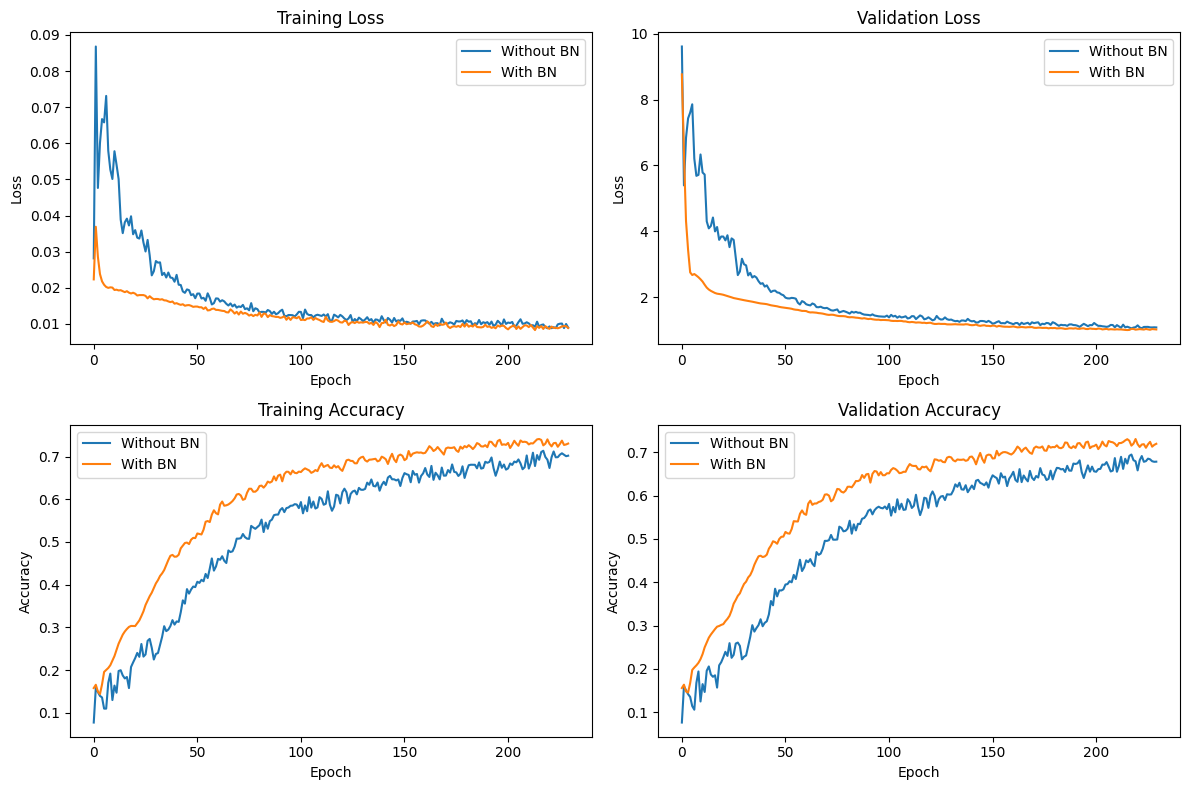

In [ ]:

print("\nComparing models with and without batch normalization...")

model_no_bn = NeuralNetwork(input_size, hidden_size, output_size, use_batchnorm=False)
optimizer = Adam(learning_rate=0.001, beta1=0.9, beta2=0.999)
train_loss_no_bn, val_loss_no_bn, train_acc_no_bn, val_acc_no_bn = model_no_bn.train(
    X_train_flat, y_train, X_val_flat, y_val,
    batch_size=batch_size, epochs=epochs,
    optimizer=optimizer, reg_strength=reg_strength,
    verbose=False
)
test_acc_no_bn = model_no_bn.compute_accuracy(X_test_flat, y_test)
print(f"Test accuracy without batch normalization: {test_acc_no_bn:.4f}")
model_bn = NeuralNetwork(input_size, hidden_size, output_size, use_batchnorm=True)
train_loss_bn, val_loss_bn, train_acc_bn, val_acc_bn = model_bn.train(
    X_train_flat, y_train, X_val_flat, y_val,
    batch_size=batch_size, epochs=epochs,
    optimizer=optimizer, reg_strength=reg_strength,
    verbose=False
)
test_acc_bn = model_bn.compute_accuracy(X_test_flat, y_test)
print(f"Test accuracy with batch normalization: {test_acc_bn:.4f}")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_loss_no_bn, label='Without BN')
plt.plot(train_loss_bn, label='With BN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(val_loss_no_bn, label='Without BN')
plt.plot(val_loss_bn, label='With BN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_acc_no_bn, label='Without BN')
plt.plot(train_acc_bn, label='With BN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(val_acc_no_bn, label='Without BN')
plt.plot(val_acc_bn, label='With BN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



# 9. Матрица путаницы и ошибочные классификации

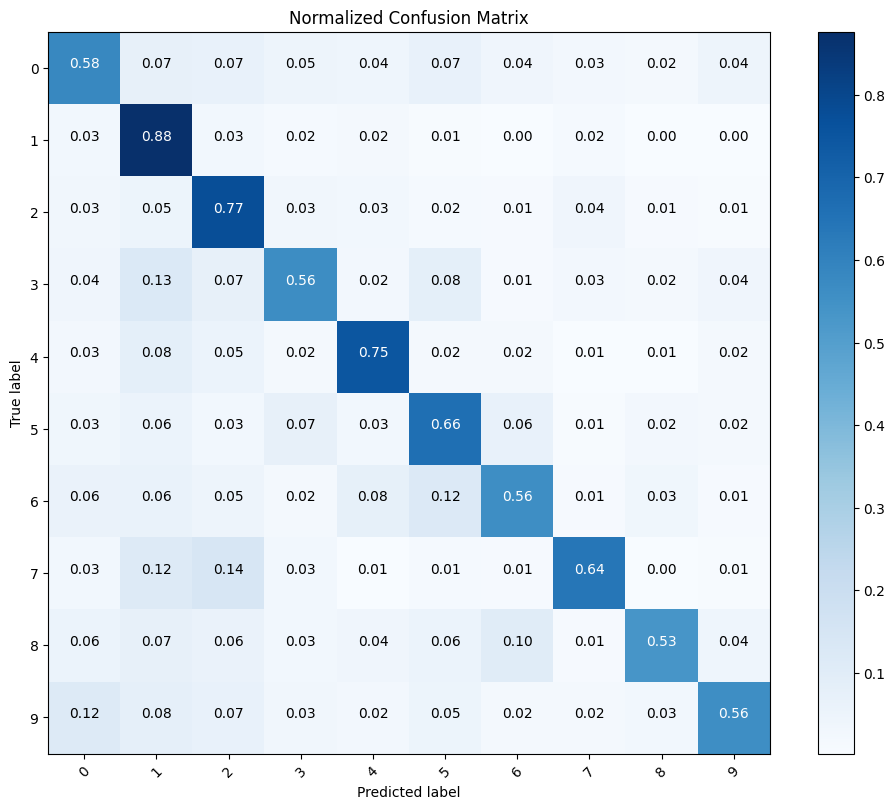

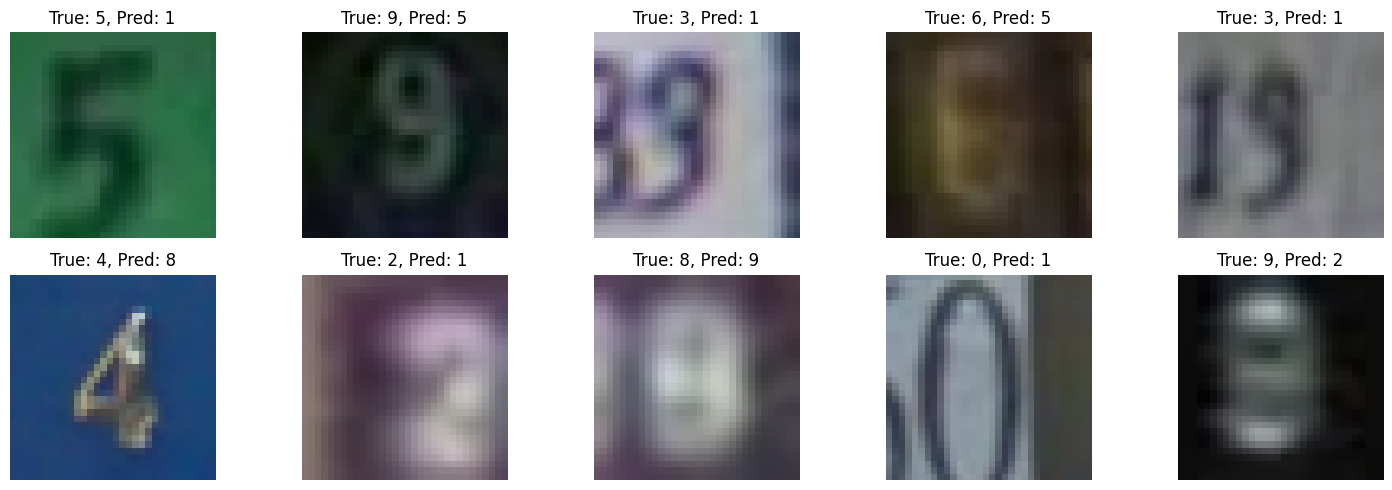

In [31]:

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

y_pred = model.predict(X_test_flat)

cm = confusion_matrix(y_test, y_pred)
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

misclassified_indices = np.where(y_pred != y_test)[0]

num_examples = min(10, len(misclassified_indices))
plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices[:num_examples]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 10. Заключение

In [37]:
print("\nЗаключение:")
print(f"Лучший оптимизатор: {max(test_accuracies.items(), key=lambda x: x[1])[0]}")
print(f"Лучший test acc: {max(test_accuracies.values()):.4f}")
print(f"После batch нормализации: {'Улучшили' if test_acc_bn > test_acc_no_bn else 'ухудшили'} accuracy на {abs(test_acc_bn - test_acc_no_bn):.4f}")


Заключение:
Лучший оптимизатор: Momentum
Лучший test acc: 0.7052
После batch нормализации: Улучшили accuracy на 0.0361
